# Pipeline Kmeans y DBscan Run
- Todos Los Modelos Balanceados
-  DATA PREPARATION
-  Constantes modelos pipeline
-  Pipeline
 - OrdinalEncoder
 - ColumnTransformer
 - Seleccion y extracción de de caracteriticas
 - Standard Scaler
- Kmeans
- Dbscan

In [1]:
import numpy as np
import pandas as pd
from sklearn import utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

# scikit-learn==1.1.1
# from sinfo import sinfo
# sinfo()
# import sklearn
# sklearn.show_versions()

2023-10-06 00:39:24.358176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 00:39:25.331616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/azureml_py38/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-06 00:39:25.331722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/azureml_py38/lib/python3.8/site-pa

In [2]:
import metricas
from sklearn import metrics
import psutil
import GPUtil
import time

start_time = time.time()
psutil.cpu_times()
psutil.virtual_memory()
psutil.disk_partitions()

t_cpu = psutil.cpu_times()
cpu_usage = psutil.cpu_percent(1)
mem_usage = psutil.virtual_memory().percent
disco2 = psutil.disk_usage('/')

In [3]:
import joblib
import os

def pickle_model(pkl_filename, operation, model):
    if operation == 'wb':
        with open(pkl_filename, operation) as file:
            joblib.dump(model, file)
        print('Modelo', pkl_filename, 'guardado.')
            
    elif operation == 'rb':
        with open(pkl_filename, operation) as file:
            joblib_model =joblib.load(file)
        print('Lectura de', pkl_filename, '.')
        return joblib_model

In [4]:
def new_categories(df,old_keys,new_keys):

    choices = ['DDoS_UDP','Reconnaissance','DDoS_TCP']

    for i,v in enumerate(old_keys):
        condiciones = [
        df[ v ].str.contains('DDoS_UDP|DoS_UDP'),
        df[ v ].str.contains('Reconnaissance_OS_Fingerprint|Reconnaissance_Service_Scan'),
        df[ v ].str.contains('DDoS_TCP|DoS_TCP')
        ]
        df[new_keys[i]] = np.select(condiciones,choices, default='Normal')
        print(df[new_keys[i]].value_counts())

In [5]:
import os
import psutil
import time
import datetime

def cpu_info():
    cpu = psutil.Process(os.getpid()).cpu_percent (1) # tasa de uso de CPU en un segundo, unidad
    cpu_per = '% .2f %%'% cpu # se convierte en un porcentaje, mantenga dos decimales
    return (cpu_per , cpu)

def mem_info():
    mem = psutil.Process(os.getpid()).memory_percent()
    
    mem_per = '%.2f%%' % mem
    return (mem_per , mem)


def disk_info() :
    c_info = psutil.disk_usage('/')
    c_per = '%.2f%%' % c_info[3]
    return c_per


def medida_tiempo() :
    tiempo = datetime.datetime.now()
    return tiempo


def tiempo_total(t1 , t2) :
    t_total = t2 - t1
    return t_total


def children_process(cpu , mem) :
    c_list= []
    children_list = psutil.Process(os.getpid()).children()
    if len(children_list) > 0:
        for i in range( len (children_list) ):
            c_list += [children_list[ i ].pid]
        info_children = add_children(c_list , cpu , mem)
        return info_children
    else:
        return 'Not children'
    


def add_children(c_list , cpu , mem) :
    cpu_su = cpu[1]
    mem_su = mem[1]
    for i in range( len (c_list)):
        pid = c_list[i]
        cpu_child = psutil.Process(pid).cpu_percent (1)
        mem_child = psutil.Process( pid ).memory_percent()
#         print( cpu_child , mem_child )
        cpu_su += cpu_child
        mem_su += mem_child
    cpu_total = '%.2f%%' % cpu_su
    mem_total = '%.2f%%' % mem_su
    return (cpu_total , mem_total)   

def print_info(cpu , mem , disco , t , otro) :
    if otro == 'Not children':
        var_prin = f'cpu: {cpu[0]}, memoria: {mem[0]}, disco: {disco}, tiempo: {t}'
    if otro != 'Not children':
        var_prin = f'cpu: {otro[0]}, memoria: {otro[1]}, disco: {disco}, tiempo: {t}'
    return var_prin

if __name__ == '__main__' :
    t1 = medida_tiempo()
    cpu = cpu_info()
    mem = mem_info()
    disco = disk_info()
    otro = children_process(cpu , mem)
    t2 = medida_tiempo()
    t= tiempo_total(t1, t2)
    print_info(cpu , mem , disco , t , otro)

# DATA PREPARATION

In [6]:
df=pd.read_csv('IoT_Dataset_over.csv', sep=',',index_col=0,low_memory=False)
df

,delta_time,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,...,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin,label,en_protocols,tipo_ataque,protocols
194778,0.000001,30578.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,30.0,DoS_TCP,TCP
261903,0.000017,36529.0,61322.0,70,8.0,64.5,3.0,48.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,9.0,Reconnaissance_Service_Scan,ICMP
206551,0.000001,33111.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,30.0,DoS_TCP,TCP
34944,0.000001,49203.0,2006.0,60,NaN,41.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,30.0,Reconnaissance_OS_Fingerprint,TCP
133936,0.000055,39705.0,49179.0,70,8.0,64.4,3.0,48.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,9.0,Reconnaissance_Service_Scan,ICMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40755,0.003455,8080.0,80.0,1418,NaN,127.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,30.0,Normal,TCP
127988,0.000001,33223.0,1166.0,60,NaN,42.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,30.0,Reconnaissance_OS_Fingerprint,TCP
49206,0.000001,1233.0,62169.0,60,NaN,64.0,NaN,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0,30.0,Normal,TCP
232614,0.000000,55499.0,89.0,60,NaN,47.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,30.0,Reconnaissance_OS_Fingerprint,TCP


In [7]:
df.tipo_ataque.value_counts()

Reconnaissance_Service_Scan      38162
DoS_UDP                          38162
DDoS_TCP                         38162
DDoS_UDP                         38162
Reconnaissance_OS_Fingerprint    38162
Normal                           38162
DoS_TCP                          38162
Name: tipo_ataque, dtype: int64

In [8]:
X = df.drop(['label','tipo_ataque', 'protocols'],axis=1)
y = y =df['label']
X

,delta_time,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,...,tcp_flags_ns,tcp_flags_cwr,tcp_flags_ecn,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin,en_protocols
194778,0.000001,30578.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
261903,0.000017,36529.0,61322.0,70,8.0,64.5,3.0,48.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
206551,0.000001,33111.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
34944,0.000001,49203.0,2006.0,60,NaN,41.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
133936,0.000055,39705.0,49179.0,70,8.0,64.4,3.0,48.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40755,0.003455,8080.0,80.0,1418,NaN,127.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
127988,0.000001,33223.0,1166.0,60,NaN,42.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
49206,0.000001,1233.0,62169.0,60,NaN,64.0,NaN,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,30.0
232614,0.000000,55499.0,89.0,60,NaN,47.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0


# Constantes modelos pipeline

In [9]:
#EJERCICIO 10

elimina = ['number__tcp_flags_cwr', 'number__tcp_flags_ecn', 
           'number__tcp_flags_urg', 'number__tcp_flags_ack',
           'number__tcp_flags_push', 'number__tcp_flags_reset',
           'number__tcp_flags_fin', 'number__icmp_type',
           'number__ip_flags_rb', 'number__tcp_flags_res']
metodo_scaler= 'scaler'
strategy='constant'
fill_value=-1
# kmeans
n_clusters=29
# pca
n_components= 6
# dbscan
eps= 0.01924652961188758
m_samples= 29

# #EJERCICIO 17

# elimina = ['number__tcp_flags_cwr', 'number__tcp_flags_ecn', 
#            'number__tcp_flags_urg', 'number__tcp_flags_ack',
#            'number__tcp_flags_push', 'number__tcp_flags_reset',
#            'number__tcp_flags_fin', 'number__icmp_type',
#            'number__ip_flags_rb', 'number__tcp_flags_res']
# metodo_scaler= 'scaler'
# strategy='constant'
# fill_value=-1
# n_clusters=7
# n_components= 6
# eps= 0.039984318617935714
# m_samples= 22

In [10]:
print(fill_value)
print(elimina)
print(n_clusters)
print(eps)

-1
['number__tcp_flags_cwr', 'number__tcp_flags_ecn', 'number__tcp_flags_urg', 'number__tcp_flags_ack', 'number__tcp_flags_push', 'number__tcp_flags_reset', 'number__tcp_flags_fin', 'number__icmp_type', 'number__ip_flags_rb', 'number__tcp_flags_res']
29
0.01924652961188758


In [11]:
# PIPELINE
# seleccion de tipo de columna numerico y categorica
numerical_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
print(numerical_features)
print(categorical_features)

['delta_time', 'port_src', 'port_dst', 'frame_len', 'udp_len', 'ip_ttl', 'icmp_type', 'tos', 'ip_flags_rb', 'ip_flags_df', 'ip_flags_mf', 'tcp_flags_res', 'tcp_flags_ns', 'tcp_flags_cwr', 'tcp_flags_ecn', 'tcp_flags_urg', 'tcp_flags_ack', 'tcp_flags_push', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_flags_fin', 'en_protocols']
[]


In [12]:
numeric_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy=strategy, fill_value=fill_value))])

In [13]:
## OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
categorical_pipeline = Pipeline(steps=[
    ('OrdinalEncoder',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])

## ColumnTransformer

In [14]:
preprocessor_1 = ColumnTransformer(transformers=[('number', numeric_pipeline, numerical_features),
                                                 ('category', categorical_pipeline, categorical_features)])
pp1=preprocessor_1.fit_transform(X)
columns=preprocessor_1.get_feature_names_out().tolist()
# se creand 16 nuevas variables
print(len(columns))
columns

22


['number__delta_time',
 'number__port_src',
 'number__port_dst',
 'number__frame_len',
 'number__udp_len',
 'number__ip_ttl',
 'number__icmp_type',
 'number__tos',
 'number__ip_flags_rb',
 'number__ip_flags_df',
 'number__ip_flags_mf',
 'number__tcp_flags_res',
 'number__tcp_flags_ns',
 'number__tcp_flags_cwr',
 'number__tcp_flags_ecn',
 'number__tcp_flags_urg',
 'number__tcp_flags_ack',
 'number__tcp_flags_push',
 'number__tcp_flags_reset',
 'number__tcp_flags_syn',
 'number__tcp_flags_fin',
 'number__en_protocols']

In [15]:
pp1 = pd.DataFrame(pp1, index=X.index, columns=columns)
print(pp1.columns)
pp1

Index(['number__delta_time', 'number__port_src', 'number__port_dst',
       'number__frame_len', 'number__udp_len', 'number__ip_ttl',
       'number__icmp_type', 'number__tos', 'number__ip_flags_rb',
       'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_res',
       'number__tcp_flags_ns', 'number__tcp_flags_cwr',
       'number__tcp_flags_ecn', 'number__tcp_flags_urg',
       'number__tcp_flags_ack', 'number__tcp_flags_push',
       'number__tcp_flags_reset', 'number__tcp_flags_syn',
       'number__tcp_flags_fin', 'number__en_protocols'],
      dtype='object')


,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__icmp_type,number__tos,number__ip_flags_rb,number__ip_flags_df,...,number__tcp_flags_ns,number__tcp_flags_cwr,number__tcp_flags_ecn,number__tcp_flags_urg,number__tcp_flags_ack,number__tcp_flags_push,number__tcp_flags_reset,number__tcp_flags_syn,number__tcp_flags_fin,number__en_protocols
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,3.0,48.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,3.0,48.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40755,0.003455,8080.0,80.0,1418.0,-1.0,127.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
127988,0.000001,33223.0,1166.0,60.0,-1.0,42.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0
49206,0.000001,1233.0,62169.0,60.0,-1.0,64.0,-1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,30.0
232614,0.000000,55499.0,89.0,60.0,-1.0,47.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0


## Seleccion y extracción de de caracteriticas

In [16]:
# CREACION DE UNA CONEXION PIPELINE
#  Colocar nombres
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
class del_columns(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns
#         print('delect columns,columns')
        
        
    def fit(self, X , y=None):
#         print('fit')
#         print(type(X))
        return self
        
    def transform(self, X , y=None):
#         print('trans')
        X =pd.DataFrame(X, columns=columns)
#         print(X.head(5))

        X_ =X.drop(elimina,axis=1)
#         print(X_.columns)
#         X_= X_.to_numpy()        
        return X_

In [17]:
preprocessor_2 = Pipeline(steps=[('prepro_1_num_cat',preprocessor_1),
                                 ('del_columns',del_columns(columns)),
                                 ])
pp1=preprocessor_2.fit_transform(X)
pp1.index = X.index
pp1

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,number__en_protocols
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,48.0,0.0,0.0,-1.0,-1.0,9.0
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,0.0,0.0,0.0,0.0,1.0,30.0
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,48.0,0.0,0.0,-1.0,-1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40755,0.003455,8080.0,80.0,1418.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0
127988,0.000001,33223.0,1166.0,60.0,-1.0,42.0,0.0,0.0,0.0,0.0,1.0,30.0
49206,0.000001,1233.0,62169.0,60.0,-1.0,64.0,0.0,1.0,0.0,0.0,0.0,30.0
232614,0.000000,55499.0,89.0,60.0,-1.0,47.0,0.0,0.0,0.0,0.0,1.0,30.0


## Standard Scaler

In [18]:
# definicion de las conexiones de la tuberia en orden secuencial

preprocessor_3 = Pipeline(steps=[('prepro_2_del',preprocessor_2),
#                                  (metodo_scaler,StandardScaler()),
#                                  ('del_columns',del_columns(columns)),])
                                 (metodo_scaler,StandardScaler()),#])
                                 ('pca', PCA(n_components= n_components))])
# datos para realizar las metricas internas
preprocessor_3.fit(X)
pp3 = preprocessor_3.transform(X)
# #Con PCA
pp3 = pd.DataFrame(pp3, index=X.index)
# #Sin PCA
# pp3 = pd.DataFrame(pp3, index=X.index,columns=pp1.columns)
#DIVISION DE CONJUNTO DE DATOS ENTRENENAMEINTO Y PRUEBAS
X_Train, X_Test, y_Train, y_Test = train_test_split(pp3, y, test_size=0.2, random_state=42)
pp3

,0,1,2,3,4,5
194778,-0.713232,-0.827655,0.180136,0.499420,-0.146031,-0.031880
261903,-0.050008,6.402520,5.271844,-0.381051,-0.595217,-0.416760
206551,-0.776956,-0.834207,0.191326,0.513012,-0.165826,-0.039776
34944,-1.792818,-0.555280,0.000232,0.447610,-0.136757,-0.002435
133936,-0.138752,6.243534,4.938306,0.090871,-0.776742,-0.608784
...,...,...,...,...,...,...
40755,3.600435,-2.291604,1.740206,1.241031,-0.446027,-0.295182
127988,-1.371227,-0.532749,-0.084690,0.393538,-0.027118,0.032421
49206,0.188254,0.245083,2.438187,-5.189026,0.690898,2.341276
232614,-1.831806,-0.645519,0.031398,0.554463,-0.236666,-0.065124


In [19]:
preprocessor_3 

Pipeline(steps=[('prepro_2_del',
                 Pipeline(steps=[('prepro_1_num_cat',
                                  ColumnTransformer(transformers=[('number',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(fill_value=-1,
                                                                                                  strategy='constant'))]),
                                                                   ['delta_time',
                                                                    'port_src',
                                                                    'port_dst',
                                                                    'frame_len',
                                                                    'udp_len',
                                                                    'ip_ttl',
                                                                    'icmp_type',
                                                                    'tos',
                                                                    'ip_flags_rb',
                                                                    'ip_flags_df',
                                                                    'ip_flags_mf',
                                                                    'tcp_flags_res',
                                                                    'tcp_flags_ns',
                                                                    'tcp...
                                                       'number__ip_flags_mf',
                                                       'number__tcp_flags_res',
                                                       'number__tcp_flags_ns',
                                                       'number__tcp_flags_cwr',
                                                       'number__tcp_flags_ecn',
                                                       'number__tcp_flags_urg',
                                                       'number__tcp_flags_ack',
                                                       'number__tcp_flags_push',
                                                       'number__tcp_flags_reset',
                                                       'number__tcp_flags_syn',
                                                       'number__tcp_flags_fin',
                                                       'number__en_protocols']))])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=6))])

# KMeans

In [20]:
kmeans_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('kmeans',KMeans(n_clusters=n_clusters))])

In [21]:
kmeans_1

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin',
                                                                        'number__en_protocols']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('kmeans', KMeans(n_clusters=29))])

In [22]:
#kmeans_1[0].fit_transform(X)

array([[-0.713232  , -0.8276545 ,  0.1801359 ,  0.49942016, -0.14603104,
        -0.03187976],
       [-0.0500082 ,  6.40251979,  5.27184399, -0.38105082, -0.59521707,
        -0.41675991],
       [-0.77695614, -0.83420687,  0.1913264 ,  0.51301214, -0.16582595,
        -0.03977577],
       ...,
       [ 0.1882542 ,  0.24508339,  2.43818743, -5.18902558,  0.69089816,
         2.34127597],
       [-1.83180625, -0.64551924,  0.03139808,  0.5544628 , -0.23666618,
        -0.06512448],
       [-2.03389426, -0.55773492, -0.05514528,  0.53930506, -0.18961322,
        -0.03593613]])

In [39]:
kmeans_1 = KMeans(n_clusters=n_clusters)
kmeans_1.fit(X_Train) 
y_pred_kmeans = kmeans_1.predict(X_Test)

In [23]:
# strategy, n_components, n_clusters ss
df1_1 = pd.DataFrame()
df1=pp1.copy()
for k in range(10):
    print('k   ',{k})
    predictions_1 = kmeans_1.fit_predict(X)
    
    df1['cluster'] =pd.DataFrame(predictions_1, index=X.index)
    df1[['label','tipo_ataque']] = df[['label','tipo_ataque']].copy()    
    df1.head(5)
    # metricas por tipo de ataque
    l=metricas.y(df1,0, n_clusters,'cluster','tipo_ataque')
    metricas.metricas(df1,'tipo_ataque', 'Trans_cluster')
    metricas.metrica_internas(pp3,df1['cluster'])
    
    #metricas.save_csv(df1,pp3, f'{metodo_scaler}_kmeans_{k}_{strategy}_{n_components}_{n_clusters}_{fill_value}_borrar.csv')
    mm= metricas.matriz(df1,'tipo_ataque','Trans_cluster')
    print(mm[0])    
    print(mm[1])  
    df1_1 = pd.concat([df1_1,mm[1].iloc[:,:4], mm[1].iloc[:,-3:]],axis=1)
    #print(metricas. matriz(df1).to_csv(f'{metodo_scaler}_kmeans_{k}_{strategy}_{n_components}_{n_clusters}_{fill_value}_matriz.csv'))

df1_1.columns=[f'{l}_{j}' for j in range(int(len(df1_1.columns)/7)) for l in ['tp','fp','fn','tn','recall','precision','f1']]
df1_1

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

k    {0}
0 DoS_UDP
1 Reconnaissance_OS_Fingerprint
2 Normal
3 Reconnaissance_Service_Scan
4 Normal
5 Normal
6 Normal
7 DoS_TCP
8 Reconnaissance_Service_Scan
9 Reconnaissance_Service_Scan
10 Normal
11 Reconnaissance_OS_Fingerprint
12 Normal
13 Normal
14 Reconnaissance_Service_Scan
15 Normal
16 Normal
17 DDoS_UDP
18 Reconnaissance_Service_Scan
19 Reconnaissance_OS_Fingerprint
20 DDoS_TCP
21 Normal
22 Reconnaissance_Service_Scan
23 Reconnaissance_Service_Scan
24 Reconnaissance_OS_Fingerprint
25 DDoS_UDP
26 Normal
27 Normal
28 Reconnaissance_OS_Fingerprint
                               precision    recall  f1-score   support

                     DDoS_TCP       0.51      0.51      0.51     38162
                     DDoS_UDP       0.81      0.71      0.76     38162
                      DoS_TCP       0.51      0.53      0.52     38162
                      DoS_UDP       0.75      0.88      0.81     38162
                       Normal       0.96      0.76      0.85     38162
Reconnaissance

In [24]:
df1.head(5)

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,number__en_protocols,cluster,label,tipo_ataque,Trans_cluster
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0,25,1,DoS_TCP,DDoS_TCP
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,48.0,0.0,0.0,-1.0,-1.0,9.0,22,1,Reconnaissance_Service_Scan,Reconnaissance_Service_Scan
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0,25,1,DoS_TCP,DDoS_TCP
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1,Reconnaissance_OS_Fingerprint,Reconnaissance_OS_Fingerprint
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,48.0,0.0,0.0,-1.0,-1.0,9.0,22,1,Reconnaissance_Service_Scan,Reconnaissance_Service_Scan


In [25]:
def metrica_internas(pp3,cluster):
    chs = round(metrics.calinski_harabasz_score(pp3, cluster),5)
    dbs = round(metrics.davies_bouldin_score(pp3, cluster),5)
    return (chs,dbs)   

In [26]:
chs,dbs=metricas.metrica_internas(pp3,df1['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

Calinski: 652466.55951
Davies: 0.65453


In [27]:
# disminucion de ataques de tipos de ataque a categorias
old_keys=['tipo_ataque', 'Trans_cluster']
new_keys=['categoria','Trans_cluster_']

new_categories(df1,old_keys,new_keys)

DDoS_TCP          76324
Reconnaissance    76324
DDoS_UDP          76324
Normal            38162
Name: categoria, dtype: int64
Reconnaissance    80768
DDoS_UDP          78039
DDoS_TCP          77189
Normal            31138
Name: Trans_cluster_, dtype: int64


In [28]:
# metricas generadas por la creación de categorias()
metricas.metricas(df1,'categoria', 'Trans_cluster_')
chs,dbs=metricas.metrica_internas(pp3,df1['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

#otras mtericas
import psutil
import GPUtil
import matplotlib.pyplot as plt

#t1 = medida_tiempo()
disco = disk_info()

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

                precision    recall  f1-score   support

      DDoS_TCP       0.99      1.00      0.99     76324
      DDoS_UDP       0.98      1.00      0.99     76324
        Normal       0.94      0.77      0.84     38162
Reconnaissance       0.89      0.95      0.92     76324

      accuracy                           0.95    267134
     macro avg       0.95      0.93      0.94    267134
  weighted avg       0.95      0.95      0.95    267134

Purity  0.95084
homogeneity_score:  0.8641
completeness_score:  0.87798
v_measure_score:  0.87098
adjusted_mutual_info_score:  0.87098
Calinski: 652466.55951
Davies: 0.65453
Rendimiento de Gastos Generales:
tiempo:--- 3171.4990067481995 Segundos ---
tiempo_cpu scputimes(user=106.84, nice=121.38, system=148.23, idle=4097.27, iowait=197.9, irq=0.0, softirq=9.78, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.00%
%_mem 5.90%
consumo de disco 46.30%


In [29]:
mm= metricas.matriz(df1,'categoria','Trans_cluster_')
print(mm[0])    
print(mm[1])  


DDoS_TCP
         Positive Negative
Positive    76270       54
Negative      919   189891

Reconnaissance
         Positive Negative
Positive    72144     4180
Negative     8624   182186

DDoS_UDP
         Positive Negative
Positive    76317        7
Negative     1722   189088

Normal
         Positive Negative
Positive    29270     8892
Negative     1868   227104
  Cantidad coincidencia % prediccion total prediciones
0    76324        76270     0.999292             77189
1   190810       189891     0.995184            189945
                   tp    fp    fn      tn  tp+fn  tp+fp   fn+tn   fp+tn  \
DDoS_TCP        76270   919    54  189891  76324  77189  189945  190810   
Reconnaissance  72144  8624  4180  182186  76324  80768  186366  190810   
DDoS_UDP        76317  1722     7  189088  76324  78039  189095  190810   
Normal          29270  1868  8892  227104  38162  31138  235996  228972   

                  recall precision        F1  
DDoS_TCP        0.999292  0.988094  0.993662

In [30]:
## guarda lista para aplicacion

l=metricas.y(df1.drop(['Trans_cluster'],axis=1),0, n_clusters,'cluster','categoria')
with open('list_kmeans_over.txt','w') as f:
    f.write(str(l))

0 Reconnaissance
1 Normal
2 DDoS_UDP
3 Normal
4 Reconnaissance
5 Normal
6 Normal
7 Reconnaissance
8 Reconnaissance
9 Normal
10 Reconnaissance
11 Normal
12 Reconnaissance
13 Reconnaissance
14 Reconnaissance
15 Normal
16 DDoS_UDP
17 DDoS_TCP
18 Reconnaissance
19 Normal
20 Normal
21 Normal
22 Reconnaissance
23 Normal
24 Normal
25 DDoS_TCP
26 DDoS_UDP
27 Reconnaissance
28 Reconnaissance


In [31]:
# guarda modelo pickle
print('= = ='*10,'12. Guardar el Modelo KMeans ')
pickle_model('kmeans1__EJERCICIO10_n_components6_over.pkl', 'wb', kmeans_1)

= = == = == = == = == = == = == = == = == = == = = 12. Guardar el Modelo KMeans 
Modelo kmeans1__EJERCICIO10_n_components6_over.pkl guardado.


In [ ]:
#Guardar datos y prediciones en archivo csv
#df1.to_csv('Kmeans_EJERCICIO10_over_.csv') 

In [33]:
# metricas por tipo ataque
df1['Trans_cluster'].value_counts()

Reconnaissance_OS_Fingerprint    54816
DoS_UDP                          44497
DoS_TCP                          39448
DDoS_TCP                         37741
DDoS_UDP                         33542
Normal                           31138
Reconnaissance_Service_Scan      25952
Name: Trans_cluster, dtype: int64

In [34]:
# metricas por categoria
df1['Trans_cluster_'].value_counts()

Reconnaissance    80768
DDoS_UDP          78039
DDoS_TCP          77189
Normal            31138
Name: Trans_cluster_, dtype: int64

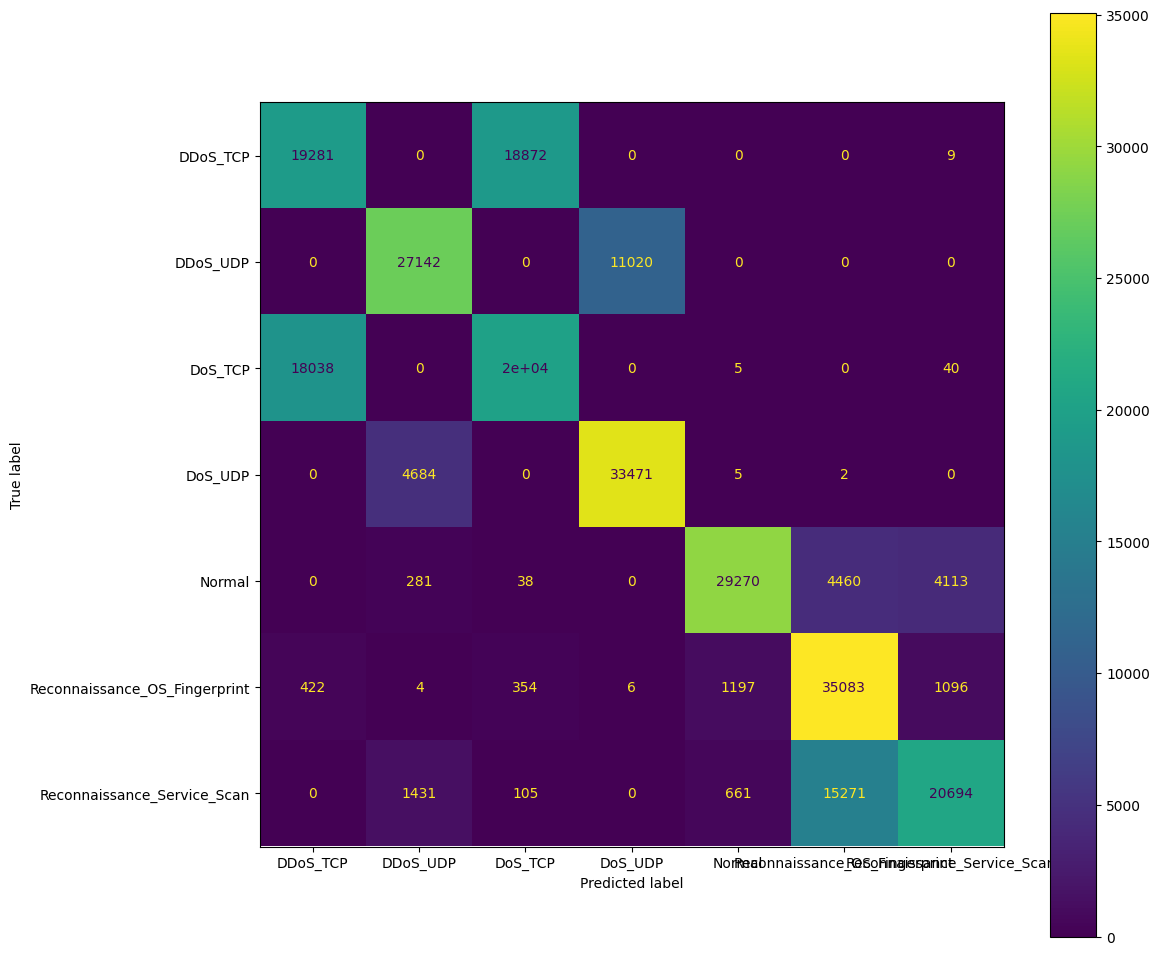

In [35]:
# metricas por tipo de ataque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','DoS_TCP','DoS_UDP','Normal','Reconnaissance_OS_Fingerprint','Reconnaissance_Service_Scan']
cm=confusion_matrix(df1['tipo_ataque'], df1['Trans_cluster'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

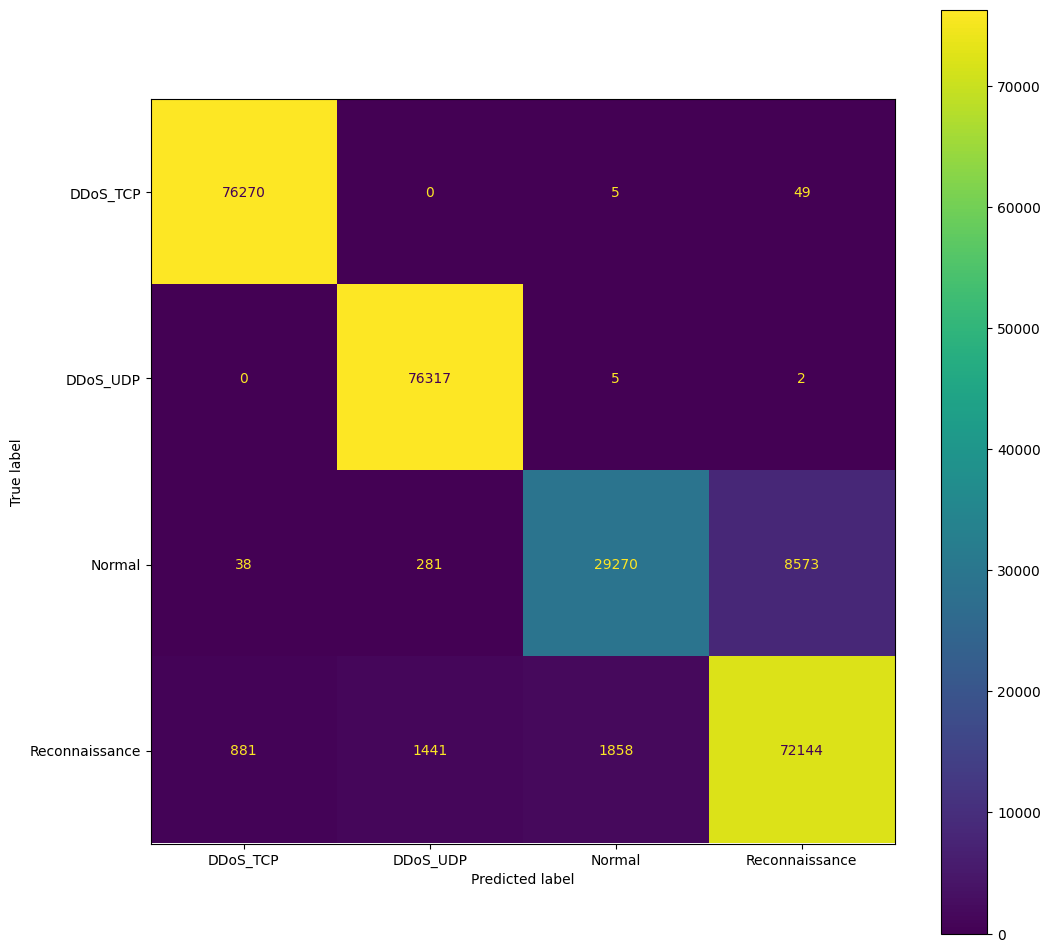

In [36]:
# metricas por categoria
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','Normal','Reconnaissance']
cm=confusion_matrix(df1['categoria'], df1['Trans_cluster_'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [37]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1200 

# Explicabilidad Kmeans

In [40]:
# Produce the SHAP values kmeans
kmeans_explainer = shap.KernelExplainer(kmeans_1.predict,X_Test.sample(500))

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [41]:
kmeans_shap_values = kmeans_explainer.shap_values(X_Test.sample(500))

  0%|          | 0/500 [00:00<?, ?it/s]

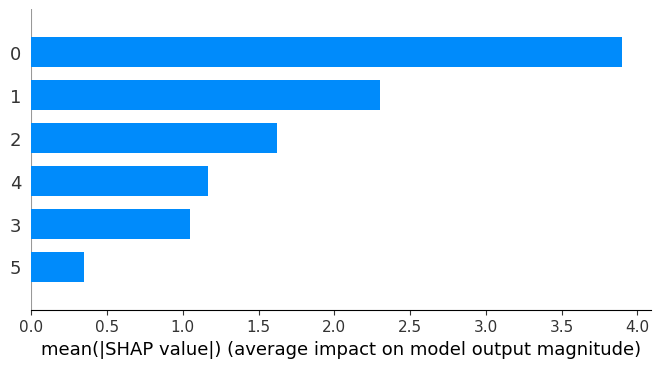

In [42]:
# Primera forma de visualizar los SHAP values kMeans
shap.summary_plot(kmeans_shap_values, X_Test, plot_type='bar')

In [43]:
pd.DataFrame(kmeans_shap_values, columns=X_Train.columns)[0].abs().mean()

3.8964471333333237

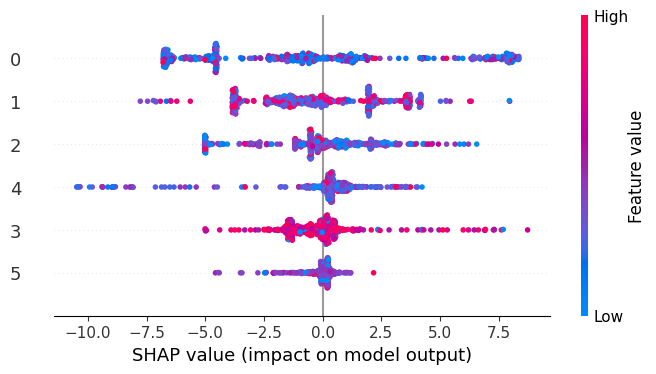

In [44]:
#Segunda Forma de Calcular los SHAP values Kmeans
shap.summary_plot(kmeans_shap_values, X_Test.sample(500))

In [ ]:
# # organizacion excel
# pp1_ = pd.concat([pp1,df['protocols'],df1[['label','tipo_ataque','Trans_cluster','cluster']]],axis=1)
# pp1_

In [ ]:
# pp1_ = pd.concat([pp1,df['protocols'],df1[['label','tipo_ataque','Trans_cluster','cluster']]],axis=1)

# d=['min','max','count']
# ata=la_matriz[0]

# c_olumn =['number__delta_time', 'number__port_src', 'number__port_dst', 'number__frame_len', 'number__udp_len', 'number__ip_ttl',
#           'number__tos', 'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_ns', 'number__tcp_flags_syn',
#           'category__protocols','Trans_cluster','cluster','tipo_ataque','label','protocols']
# a0=pp1_[['number__delta_time', 'number__port_src', 'number__port_dst', 'number__frame_len', 'number__udp_len', 'number__ip_ttl',
#          'number__tos', 'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_ns', 'number__tcp_flags_syn',
#          'category__protocols','Trans_cluster','cluster','tipo_ataque','label','protocols']][pp1_['Trans_cluster']==ata].groupby(['cluster','tipo_ataque']).agg({ i:{'min','max','count'} for i in c_olumn}).T
# b0=pp1_[['number__delta_time', 'number__port_src', 'number__port_dst', 'number__frame_len', 'number__udp_len', 'number__ip_ttl',
#          'number__tos', 'number__ip_flags_df', 'number__ip_flags_mf', 'number__tcp_flags_ns', 'number__tcp_flags_syn',
#          'category__protocols','Trans_cluster','cluster','tipo_ataque','label','protocols']].groupby(['tipo_ataque']).agg({ i:d for i in c_olumn}).T
# pd.concat([b0.loc[:,ata],a0,],axis=1)

In [ ]:
# pp1_[pp1_['cluster']==5]['category__protocols'].value_counts()

# DBscan

In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
dbscan_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('dbscan',DBSCAN(eps=eps, min_samples= m_samples))])

In [ ]:
dbscan_1.fit(X)

In [ ]:
# con duplicados
predictions_2 = dbscan_1.fit_predict(X)
df2=pp1.copy()

predictions_2 = dbscan_1.fit_predict(X)
df2=pp1.copy()

# metricas por tipo de ataque
df2['cluster'] =pd.DataFrame(predictions_2, index=X.index)
df2[['label','tipo_ataque']] = df[['label','tipo_ataque']].copy()
df2.head(5)
metricas.y(df2, -1,max(df2['cluster']+1),'cluster','tipo_ataque')
metricas.metricas(df2,'tipo_ataque', 'Trans_cluster')
metricas.metrica_internas(pp3,df2['cluster'])
matriz=metricas. matriz(df2,'tipo_ataque', 'Trans_cluster')
chs,dbs=metricas.metrica_internas(pp3,df2['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')
print(matriz[0])
print(matriz[1])
max(df2['cluster'])

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

In [ ]:
matriz[1]

In [ ]:
# metricas por tipo de ataque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','DoS_TCP','DoS_UDP','Normal','Reconnaissance_OS_Fingerprint','Reconnaissance_Service_Scan']
cm=confusion_matrix(df2['tipo_ataque'], df2['Trans_cluster'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [ ]:
# disminucion de ataques de tipos de ataque a categorias
old_keys=['tipo_ataque', 'Trans_cluster']
new_keys=['categoria','Trans_cluster_']

new_categories(df2,old_keys,new_keys)

In [ ]:
pp3

In [ ]:
# metricas por categoria
metricas.metricas(df2,'categoria', 'Trans_cluster_')
chs,dbs=metricas.metrica_internas(pp3,df2['cluster'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')
matriz=metricas. matriz(df2,'categoria', 'Trans_cluster_')
print(matriz[0])
print(matriz[1])
# print(matriz[1])
max(df2['cluster'])


#otras metricas
import psutil
import GPUtil
import matplotlib.pyplot as plt

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

In [ ]:
# metricas por tipo de ataque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=['DDoS_TCP','DDoS_UDP','Normal','Reconnaissance']
cm=confusion_matrix(df2['categoria'], df2[ 'Trans_cluster_'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [ ]:
# guarda lista para aplicacion

l=metricas.y(df2.drop(['Trans_cluster'],axis=1),-1, max(df2['cluster']+1),'cluster','categoria')
with open('list_dbscan2_over.txt','w') as f:
    f.write(str(l))

In [ ]:
print('= = ='*10,'12. Guardar el Modelo KMeans ')
pickle_model('dbscan__EJERCICIO10_n_components6_fit_over.pkl', 'wb', dbscan_1)

In [ ]:
#23/11
#'list_dbscan2.txt' 'list_dbscan2.txt'
#dbscan_EJERCICIO10_.csv 

# df2.to_csv('dbscan_EJERCICIO10_.csv')

# Local outlier factor

In [56]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot
lof_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('lof',LocalOutlierFactor(novelty=True))])
lof_1

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin',
                                                                        'number__en_protocols']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('lof', LocalOutlierFactor(novelty=True))])

In [57]:
ind_train = df.loc[df['tipo_ataque'] == 'Normal'].index
cantidad = len(ind_train)*0.6
ind_train = ind_train[:int(cantidad)]

#print(cantidad)
X_train= df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad)).drop(['label','tipo_ataque'],axis=1)
print(X_train.tail(5))
y_train = df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad))['label']
print(y_train)

       delta_time  port_src  port_dst  frame_len  udp_len  ip_ttl  icmp_type  \
79927    0.057660      80.0    8080.0        783      NaN   127.0        NaN   
23124    0.038406   36532.0   20409.0         60      8.0    38.0        NaN   
83553    0.000036    8080.0      80.0       1084      NaN   127.0        NaN   
57050    0.000017   62169.0    7625.0         60      NaN    52.0        NaN   
15258    0.000141       0.0       0.0        837      NaN   127.0        NaN   

       tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
79927  0.0          0.0          0.0          0.0            0.0   
23124  0.0          0.0          0.0          0.0            NaN   
83553  0.0          0.0          0.0          0.0            0.0   
57050  0.0          0.0          0.0          0.0            0.0   
15258  0.0          0.0          0.0          0.0            0.0   

       tcp_flags_ns  tcp_flags_cwr  tcp_flags_ecn  tcp_flags_urg  \
79927           0.0            0.0        

In [58]:
last_ind = ind_train[-1]
copy = df.loc[df['tipo_ataque'] == 'Normal'].loc[last_ind:].drop([last_ind],axis=0).index
ind_test = df.loc[df['tipo_ataque'] != 'Normal'].index
ind_test =ind_test.append(copy)
X_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))].drop(['label','tipo_ataque'],axis=1)
print(X_test.head(5))
y_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))]['label']
print(y_test.head(5))

        delta_time  port_src  port_dst  frame_len  udp_len  ip_ttl  icmp_type  \
194778    0.000001   30578.0      80.0        154      NaN    64.0        NaN   
261903    0.000017   36529.0   61322.0         70      8.0    64.5        3.0   
206551    0.000001   33111.0      80.0        154      NaN    64.0        NaN   
34944     0.000001   49203.0    2006.0         60      NaN    41.0        NaN   
133936    0.000055   39705.0   49179.0         70      8.0    64.4        3.0   

         tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
194778   0.0          0.0          0.0          0.0            0.0   
261903  48.0          0.0          0.0          0.0            NaN   
206551   0.0          0.0          0.0          0.0            0.0   
34944    0.0          0.0          0.0          0.0            0.0   
133936  48.0          0.0          0.0          0.0            NaN   

        tcp_flags_ns  tcp_flags_cwr  tcp_flags_ecn  tcp_flags_urg  \
194778           0.0   

In [62]:
model_ = LocalOutlierFactor(n_neighbors=20, metric='minkowski', contamination=0.05)
y_pred_lof = model_.fit_predict(X_Test)
y_pred_lof = np.array([1 if x == -1 else 0 for x in y_pred_lof])

In [63]:
model = lof_1.fit(X_train)
model

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_res',
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin',
                                                                        'number__en_protocols']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('lof', LocalOutlierFactor(novelty=True))])

In [68]:
test_scores = lof_1.predict(X_test)
print(test_scores)
# Predict the labels (1 inlier, -1 outlier) of X according to LOF.
n_error_outliers = test_scores[test_scores == -1].size
n_error_test = test_scores[test_scores == 1].size
print(f'n_error_test {n_error_test}')
print(f'n_error_outliers {n_error_outliers}')

[-1  1 -1 ...  1  1  1]
n_error_test 69211
n_error_outliers 175026


In [69]:
# NOTA
y_test.value_counts()

1    228972
0     15265
Name: label, dtype: int64

In [70]:
X_test['Trans_predict'] = test_scores
X_test

,delta_time,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,ip_flags_mf,tcp_flags_res,tcp_flags_ns,tcp_flags_cwr,tcp_flags_ecn,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin,en_protocols,protocols,Trans_predict
194778,0.000001,30578.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,-1
261903,0.000017,36529.0,61322.0,70,8.0,64.5,3.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,ICMP,1
206551,0.000001,33111.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,-1
34944,0.000001,49203.0,2006.0,60,NaN,41.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,1
133936,0.000055,39705.0,49179.0,70,8.0,64.4,3.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,ICMP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145354,0.003110,80.0,8080.0,1435,NaN,127.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,TCP,1
16750,0.000001,36663.0,2701.0,60,NaN,55.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,1
23583,0.001513,3456.0,80.0,999,965.0,127.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,UDP,1
40755,0.003455,8080.0,80.0,1418,NaN,127.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,TCP,1


LOF con novelty= True, tiene las desventaja en este dataset debido a que existen al paquetes normales que se parence ataques

In [71]:
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == 1,0)
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == -1,1)
X_test['Trans_predict']

194778    1
261903    0
206551    1
34944     0
133936    0
         ..
145354    0
16750     0
23583     0
40755     0
49206     0
Name: Trans_predict, Length: 244237, dtype: int64

In [72]:
pp1_=preprocessor_2.fit_transform(X_test)
pp1_.index = X_test.index
pp1_

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,number__en_protocols
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,48.0,0.0,0.0,-1.0,-1.0,9.0
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,0.0,0.0,0.0,0.0,1.0,30.0
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,48.0,0.0,0.0,-1.0,-1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145354,0.003110,80.0,8080.0,1435.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0
16750,0.000001,36663.0,2701.0,60.0,-1.0,55.0,0.0,0.0,0.0,0.0,1.0,30.0
23583,0.001513,3456.0,80.0,999.0,965.0,127.0,0.0,0.0,0.0,-1.0,-1.0,33.0
40755,0.003455,8080.0,80.0,1418.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0


In [73]:
X_ = pd.concat([pp1_,X_test['Trans_predict'],y_test],axis=1)
X_

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,number__en_protocols,Trans_predict,label
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0,1,1
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,48.0,0.0,0.0,-1.0,-1.0,9.0,0,1
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0,1,1
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,48.0,0.0,0.0,-1.0,-1.0,9.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145354,0.003110,80.0,8080.0,1435.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0
16750,0.000001,36663.0,2701.0,60.0,-1.0,55.0,0.0,0.0,0.0,0.0,1.0,30.0,0,0
23583,0.001513,3456.0,80.0,999.0,965.0,127.0,0.0,0.0,0.0,-1.0,-1.0,33.0,0,0
40755,0.003455,8080.0,80.0,1418.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0


In [74]:
metricas.metricas(X_,'label','Trans_predict')

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

              precision    recall  f1-score   support

           0       0.19      0.88      0.32     15265
           1       0.99      0.76      0.86    228972

    accuracy                           0.76    244237
   macro avg       0.59      0.82      0.59    244237
weighted avg       0.94      0.76      0.82    244237

Purity  0.9375
homogeneity_score:  0.22148
completeness_score:  0.08686
v_measure_score:  0.12479
adjusted_mutual_info_score:  0.12478
Rendimiento de Gastos Generales:
tiempo:--- 5498.164206027985 Segundos ---
tiempo_cpu scputimes(user=106.84, nice=121.38, system=148.23, idle=4097.27, iowait=197.9, irq=0.0, softirq=9.78, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.00%
%_mem 5.90%
consumo de disco 46.30%


In [75]:
matriz1=metricas.matriz(X_,'label', 'Trans_predict')
matriz1[0]


1
         Positive Negative
Positive   173123    55849
Negative     1903    13362

0
         Positive Negative
Positive    13362     1903
Negative    55849   173123


,Cantidad,coincidencia,% prediccion,total prediciones
0,228972,173123,0.756088,175026
1,15265,13362,0.875336,69211


In [76]:
matriz1[1]

,tp,fp,fn,tn,tp+fn,tp+fp,fn+tn,fp+tn,recall,precision,F1
1,173123,1903,55849,13362,228972,175026,69211,15265,0.756088,0.989127,0.857049
0,13362,55849,1903,173123,15265,69211,175026,228972,0.875336,0.193062,0.31635


In [77]:
# datos para realizar las metricas internas
preprocessor_3.fit(X_test)
pp3 = preprocessor_3.transform(X_test)
# #Con PCA
pp3 = pd.DataFrame(pp3, index=X_test.index)
# #Sin PCA
# pp3 = pd.DataFrame(pp3, index=X.index,columns=pp1.columns)
pp3

,0,1,2,3,4,5
194778,-0.674235,-0.768916,0.306908,0.449435,-0.151857,-0.084084
261903,0.722594,6.918664,4.961522,-0.656947,-0.283331,-0.264046
206551,-0.742876,-0.767552,0.323110,0.457534,-0.157619,-0.097562
34944,-1.879493,-0.190111,-0.137219,0.366377,0.026170,-0.059975
133936,0.639572,6.683254,4.677470,-0.171118,-0.537052,-0.460687
...,...,...,...,...,...,...
145354,4.316859,-3.893589,4.044589,1.056635,-0.167374,-0.502599
16750,-1.209028,-0.389134,0.046214,0.285190,-0.043080,-0.022763
23583,7.761215,-3.891043,3.070493,2.655453,-5.075707,3.791838
40755,4.082762,-4.016061,3.866088,1.375102,-0.330192,-0.668599


In [78]:
chs,dbs=metricas.metrica_internas(pp3,X_['Trans_predict'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

Calinski: 13282.01772
Davies: 3.44267
Rendimiento de Gastos Generales:
tiempo:--- 6223.140403032303 Segundos ---
tiempo_cpu scputimes(user=106.84, nice=121.38, system=148.23, idle=4097.27, iowait=197.9, irq=0.0, softirq=9.78, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.00%
%_mem 5.90%
consumo de disco 46.30%


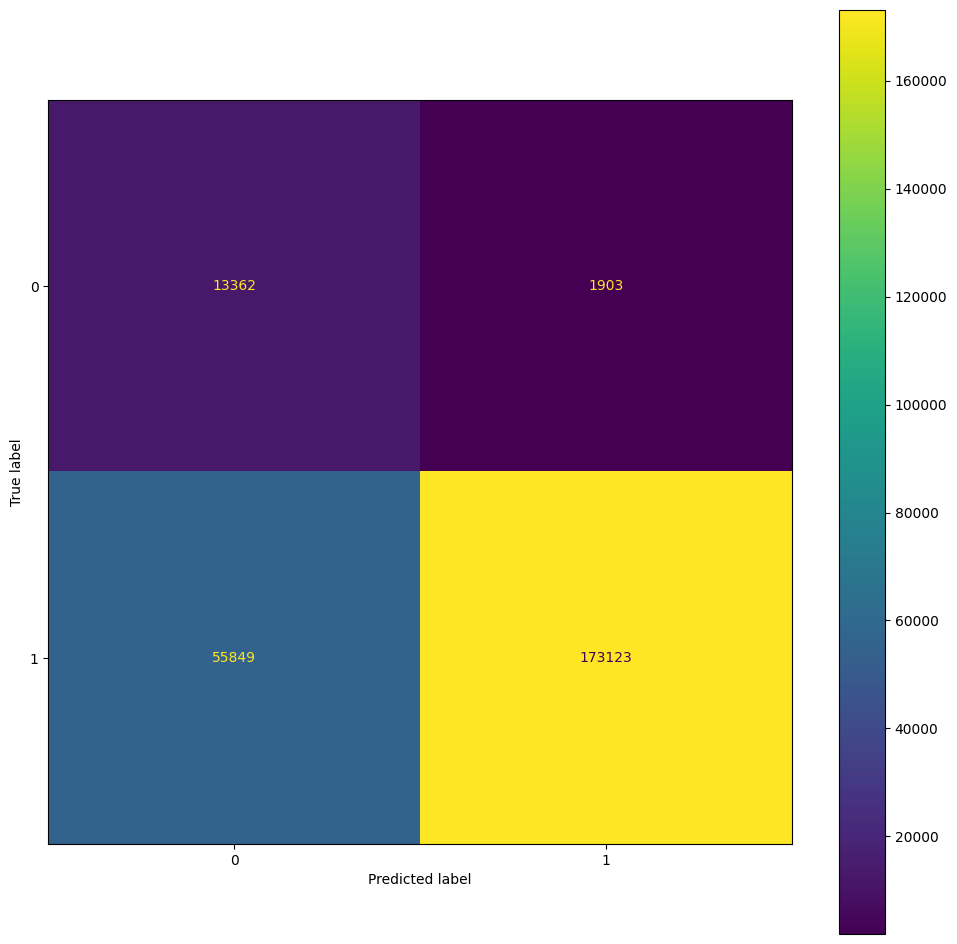

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=[0,1]
cm=confusion_matrix(X_['label'], X_['Trans_predict'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [80]:
print('= = ='*10,'12. Guardar el Modelo lof ')
pickle_model('lof__EJERCICIO10_n_components6_fit_over.pkl', 'wb', model)

= = == = == = == = == = == = == = == = == = == = = 12. Guardar el Modelo lof 
Modelo lof__EJERCICIO10_n_components6_fit_over.pkl guardado.


In [82]:
#23/11
#'list_lof_over.txt'
#lof_EJERCICIO10_.csv 

#df2.to_csv('lof_EJERCICIO10_over.csv')

In [83]:
#calcular los shap values
# Crear un objeto explainer de SHAP para LOF
lof_explainer = shap.Explainer(model_.fit_predict, X_Test.sample(500))

In [84]:
# Calcular los SHAP values LOF
lof_shap_values = lof_explainer(X_Test.sample(500))

Exact explainer: 501it [01:12,  6.25it/s]                         


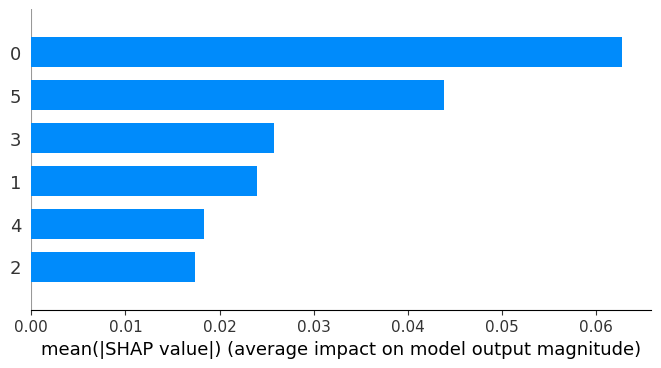

In [85]:
# Primera forma de visualizar los SHAP values LOF
shap.summary_plot(lof_shap_values, X_Test, plot_type='bar')

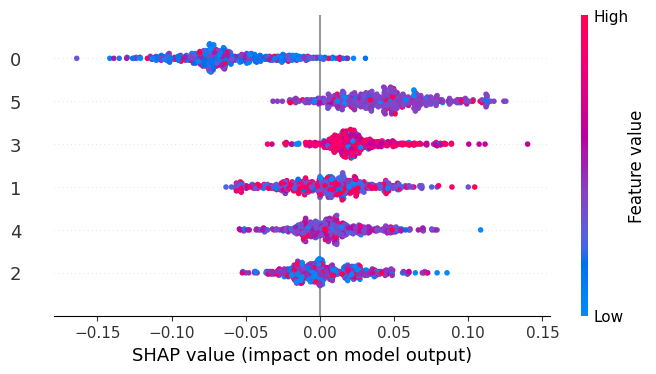

In [86]:
shap.summary_plot(lof_shap_values, X_Test.sample(500))

# Iforest
- Preparación de la data
- OrdinalEncoder
- StandardScaler
- SimpleImputer
- RandomOverSampler
- Seleccion y extracción de de caracteriticas por correlación
- PCA
- Isolation Forest

In [87]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot
ifor_1 = Pipeline(steps=[('preprocessor_3_pca',preprocessor_3),
                           ('ifor',IsolationForest(max_samples=300, contamination=0.1))])
ifor_1

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin',
                                                                        'number__en_protocols']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('ifor', IsolationForest(contamination=0.1, max_samples=300))])

In [88]:
ind_train = df.loc[df['tipo_ataque'] == 'Normal'].index
cantidad = len(ind_train)*0.8
ind_train = ind_train[:int(cantidad)]

#print(cantidad)
X_train= df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad)).drop(['label','tipo_ataque'],axis=1)
print(X_train.tail(5))
y_train = df.loc[df['tipo_ataque'] == 'Normal'].head(int(cantidad))['label']
print(y_train)

        delta_time  port_src  port_dst  frame_len  udp_len  ip_ttl  icmp_type  \
9033      0.000019    3456.0      80.0        574    540.0   127.0        NaN   
3680      0.057790      80.0    8080.0        783      NaN   127.0        NaN   
136633    0.000431      80.0      80.0        575    541.0   127.0        NaN   
142166    0.000000   50919.0    1503.0         60      NaN    41.0        NaN   
21812     0.003080      80.0    3456.0       1180   1146.0   127.0        NaN   

        tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
9033    0.0          0.0          0.0          0.0            NaN   
3680    0.0          0.0          0.0          0.0            0.0   
136633  0.0          0.0          0.0          0.0            NaN   
142166  0.0          0.0          0.0          0.0            0.0   
21812   0.0          0.0          0.0          0.0            NaN   

        tcp_flags_ns  tcp_flags_cwr  tcp_flags_ecn  tcp_flags_urg  \
9033             NaN         

In [89]:
last_ind = ind_train[-1]
copy = df.loc[df['tipo_ataque'] == 'Normal'].loc[last_ind:].drop([last_ind],axis=0).index
ind_test = df.loc[df['tipo_ataque'] != 'Normal'].index
ind_test =ind_test.append(copy)
X_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))].drop(['label','tipo_ataque'],axis=1)
print(X_test.head(5))
y_test = df.iloc[df.index.get_indexer(ind_test.difference(ind_train, sort=False))]['label']
print(y_test.head(5))

        delta_time  port_src  port_dst  frame_len  udp_len  ip_ttl  icmp_type  \
194778    0.000001   30578.0      80.0        154      NaN    64.0        NaN   
261903    0.000017   36529.0   61322.0         70      8.0    64.5        3.0   
206551    0.000001   33111.0      80.0        154      NaN    64.0        NaN   
34944     0.000001   49203.0    2006.0         60      NaN    41.0        NaN   
133936    0.000055   39705.0   49179.0         70      8.0    64.4        3.0   

         tos  ip_flags_rb  ip_flags_df  ip_flags_mf  tcp_flags_res  \
194778   0.0          0.0          0.0          0.0            0.0   
261903  48.0          0.0          0.0          0.0            NaN   
206551   0.0          0.0          0.0          0.0            0.0   
34944    0.0          0.0          0.0          0.0            0.0   
133936  48.0          0.0          0.0          0.0            NaN   

        tcp_flags_ns  tcp_flags_cwr  tcp_flags_ecn  tcp_flags_urg  \
194778           0.0   

In [90]:
model = ifor_1.fit(X_train)
model

Pipeline(steps=[('preprocessor_3_pca',
                 Pipeline(steps=[('prepro_2_del',
                                  Pipeline(steps=[('prepro_1_num_cat',
                                                   ColumnTransformer(transformers=[('number',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(fill_value=-1,
                                                                                                                   strategy='constant'))]),
                                                                                    ['delta_time',
                                                                                     'port_src',
                                                                                     'port_dst',
                                                                                     'frame_len',
                                                                                     'udp_len',
                                                                                     'ip_ttl',
                                                                                     'icmp_type',
                                                                                     'tos',
                                                                                     'ip_flags_rb',
                                                                                     'ip_flags_df',
                                                                                     'ip_flags_m...
                                                                        'number__tcp_flags_ns',
                                                                        'number__tcp_flags_cwr',
                                                                        'number__tcp_flags_ecn',
                                                                        'number__tcp_flags_urg',
                                                                        'number__tcp_flags_ack',
                                                                        'number__tcp_flags_push',
                                                                        'number__tcp_flags_reset',
                                                                        'number__tcp_flags_syn',
                                                                        'number__tcp_flags_fin',
                                                                        'number__en_protocols']))])),
                                 ('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=6))])),
                ('ifor', IsolationForest(contamination=0.1, max_samples=300))])

In [91]:
test_scores = ifor_1.predict(X_test)
print(test_scores)
# Predict the labels (1 inlier, -1 outlier) of X according to LOF.
n_error_outliers = test_scores[test_scores == -1].size
n_error_test = test_scores[test_scores == 1].size
print(f'n_error_test {n_error_test}')
print(f'n_error_outliers {n_error_outliers}')

[ 1 -1  1 ...  1  1  1]
n_error_test 210523
n_error_outliers 26082


In [92]:
# NOTA
y_test.value_counts()

1    228972
0      7633
Name: label, dtype: int64

In [93]:
X_test['Trans_predict'] = test_scores
X_test

,delta_time,port_src,port_dst,frame_len,udp_len,ip_ttl,icmp_type,tos,ip_flags_rb,ip_flags_df,ip_flags_mf,tcp_flags_res,tcp_flags_ns,tcp_flags_cwr,tcp_flags_ecn,tcp_flags_urg,tcp_flags_ack,tcp_flags_push,tcp_flags_reset,tcp_flags_syn,tcp_flags_fin,en_protocols,protocols,Trans_predict
194778,0.000001,30578.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,1
261903,0.000017,36529.0,61322.0,70,8.0,64.5,3.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,ICMP,-1
206551,0.000001,33111.0,80.0,154,NaN,64.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,1
34944,0.000001,49203.0,2006.0,60,NaN,41.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,1
133936,0.000055,39705.0,49179.0,70,8.0,64.4,3.0,48.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,ICMP,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145354,0.003110,80.0,8080.0,1435,NaN,127.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,TCP,1
16750,0.000001,36663.0,2701.0,60,NaN,55.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,TCP,1
23583,0.001513,3456.0,80.0,999,965.0,127.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,UDP,1
40755,0.003455,8080.0,80.0,1418,NaN,127.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,TCP,1


In [94]:
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == 1,0)
X_test['Trans_predict'] = X_test['Trans_predict'].mask(X_test['Trans_predict'] == -1,1)
X_test['Trans_predict']

194778    0
261903    1
206551    0
34944     0
133936    1
         ..
145354    0
16750     0
23583     0
40755     0
49206     0
Name: Trans_predict, Length: 236605, dtype: int64

In [95]:
pp1_=preprocessor_2.fit_transform(X_test)
pp1_.index = X_test.index
pp1_

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,number__en_protocols
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,48.0,0.0,0.0,-1.0,-1.0,9.0
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,0.0,0.0,0.0,0.0,1.0,30.0
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,48.0,0.0,0.0,-1.0,-1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145354,0.003110,80.0,8080.0,1435.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0
16750,0.000001,36663.0,2701.0,60.0,-1.0,55.0,0.0,0.0,0.0,0.0,1.0,30.0
23583,0.001513,3456.0,80.0,999.0,965.0,127.0,0.0,0.0,0.0,-1.0,-1.0,33.0
40755,0.003455,8080.0,80.0,1418.0,-1.0,127.0,0.0,0.0,0.0,0.0,0.0,30.0


In [96]:
X_ = pd.concat([pp1_,X_test['Trans_predict'],y_test],axis=1)
X_.head(5)

,number__delta_time,number__port_src,number__port_dst,number__frame_len,number__udp_len,number__ip_ttl,number__tos,number__ip_flags_df,number__ip_flags_mf,number__tcp_flags_ns,number__tcp_flags_syn,number__en_protocols,Trans_predict,label
194778,0.000001,30578.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1
261903,0.000017,36529.0,61322.0,70.0,8.0,64.5,48.0,0.0,0.0,-1.0,-1.0,9.0,1,1
206551,0.000001,33111.0,80.0,154.0,-1.0,64.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1
34944,0.000001,49203.0,2006.0,60.0,-1.0,41.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1
133936,0.000055,39705.0,49179.0,70.0,8.0,64.4,48.0,0.0,0.0,-1.0,-1.0,9.0,1,1


In [97]:
metricas.metricas(X_,'label','Trans_predict')
print('Rendimiento de Gastos Generales:')
print(f"tiempo:--- {time.time() - start_time} Segundos ---")
print('tiempo_cpu', t_cpu)
print('%_cpu', '%.2f%%' % cpu_usage)
print('%_mem', '%.2f%%' % mem_usage)
print ('consumo de disco', '%.2f%%' % disco2[3])

              precision    recall  f1-score   support

           0       0.03      0.90      0.06      7633
           1       0.97      0.11      0.20    228972

    accuracy                           0.14    236605
   macro avg       0.50      0.50      0.13    236605
weighted avg       0.94      0.14      0.19    236605

Purity  0.96774
homogeneity_score:  0.0001
completeness_score:  4e-05
v_measure_score:  6e-05
adjusted_mutual_info_score:  5e-05
Rendimiento de Gastos Generales:
tiempo:--- 6348.338108301163 Segundos ---
tiempo_cpu scputimes(user=106.84, nice=121.38, system=148.23, idle=4097.27, iowait=197.9, irq=0.0, softirq=9.78, steal=0.0, guest=0.0, guest_nice=0.0)
%_cpu 6.00%
%_mem 5.90%
consumo de disco 46.30%


In [98]:
matriz1=metricas.matriz(X_,'label', 'Trans_predict')
matriz1[0]


1
         Positive Negative
Positive    25310   203662
Negative      772     6861

0
         Positive Negative
Positive     6861      772
Negative   203662    25310


,Cantidad,coincidencia,% prediccion,total prediciones
0,228972,25310,0.110538,26082
1,7633,6861,0.89886,210523


In [99]:
matriz1[1]

,tp,fp,fn,tn,tp+fn,tp+fp,fn+tn,fp+tn,recall,precision,F1
1,25310,772,203662,6861,228972,26082,210523,7633,0.110538,0.970401,0.198468
0,6861,203662,772,25310,7633,210523,26082,228972,0.89886,0.0325903,0.0628999


In [100]:
# datos para realizar las metricas internas
preprocessor_3.fit(X_test)
pp3 = preprocessor_3.transform(X_test)
# #Con PCA
pp3 = pd.DataFrame(pp3, index=X_test.index)
# #Sin PCA
# pp3 = pd.DataFrame(pp3, index=X.index,columns=pp1.columns)
pp3

,0,1,2,3,4,5
194778,-0.730555,-0.671021,0.484635,0.452512,-0.173713,-0.022063
261903,1.236453,7.758613,3.618564,-0.731274,-0.206254,-0.378136
206551,-0.801695,-0.658069,0.495528,0.453721,-0.166863,-0.048212
34944,-1.912653,0.092866,-0.456725,0.309776,0.194774,-0.188831
133936,1.159238,7.436088,3.428467,-0.230808,-0.481245,-0.498500
...,...,...,...,...,...,...
145354,3.683725,-4.576254,7.324203,1.100921,0.127575,-0.413472
16750,-1.226407,-0.188594,-0.087665,0.264924,-0.027860,-0.027602
23583,8.054164,-5.792577,8.313083,3.333195,-3.271829,2.502893
40755,3.455208,-4.721436,7.165735,1.407147,-0.026565,-0.554279


In [101]:
chs,dbs=metricas.metrica_internas(pp3,X_['Trans_predict'])
print(f'Calinski: {chs}')
print(f'Davies: {dbs}')

Calinski: 20332.88423
Davies: 2.23985


In [102]:
model_ = IsolationForest(n_estimators=300, max_samples=300, contamination=0.1)
model_.fit(X_Train) 
y_pred_ifo = model_.predict(X_Test)

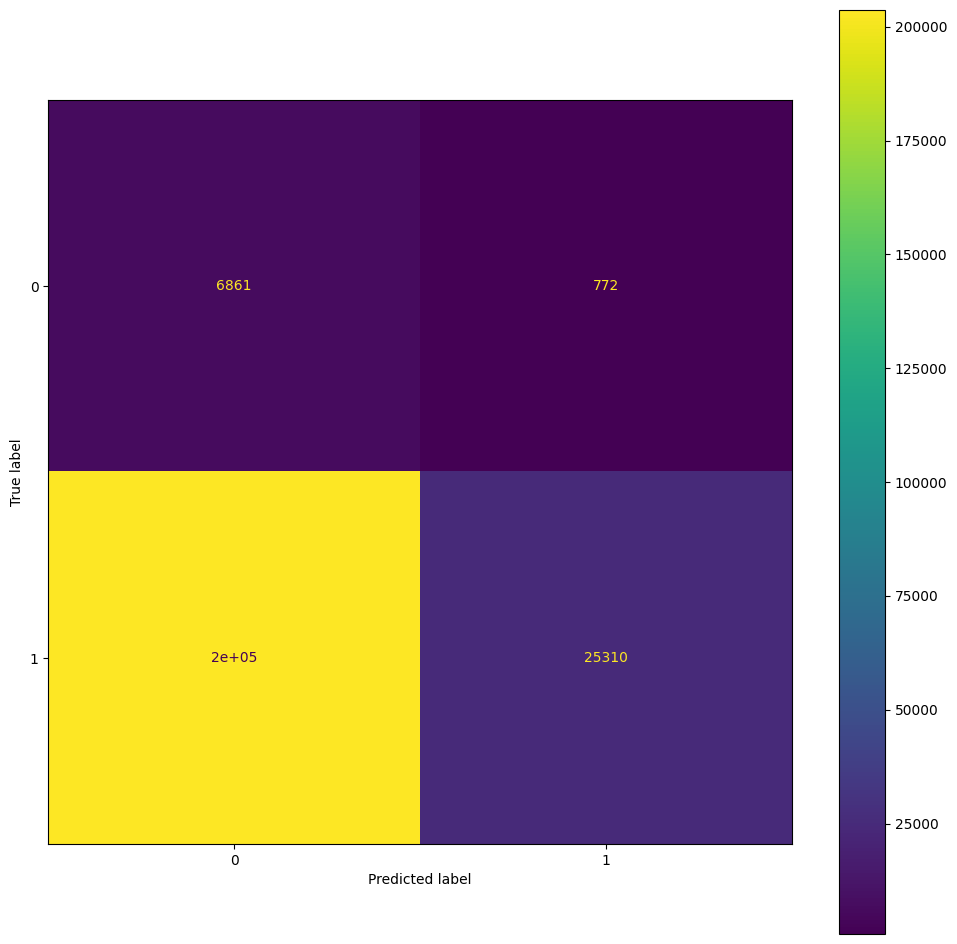

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
la_matriz=[0,1]
cm=confusion_matrix(X_['label'], X_['Trans_predict'])
disp = ConfusionMatrixDisplay(cm,display_labels=la_matriz)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [104]:
# Explicabilidad con TreeShap
Ifor_explainer = shap.Explainer(model_.fit_predict, X_Test.sample(500))

In [105]:
#Calcular los Shap Values
Ifor_shap_values = Ifor_explainer(X_Test.sample(500))

Exact explainer: 501it [08:28,  1.04s/it]                         


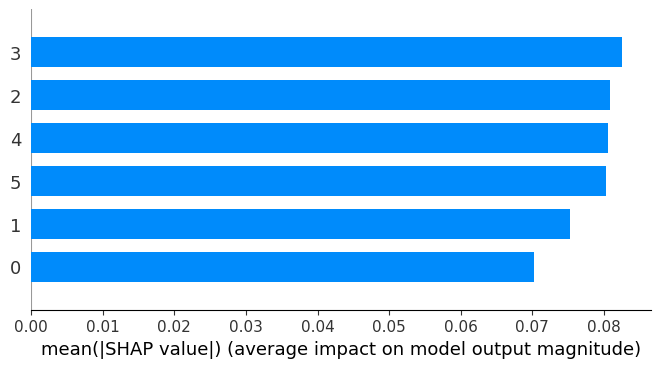

In [106]:
# Primera forma de visualizar los SHAP values kMeans
shap.summary_plot(Ifor_shap_values, X_Test, plot_type='bar')

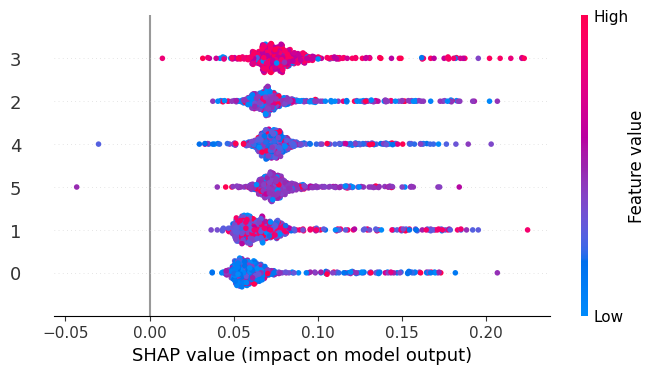

In [107]:
# Segunda Forma de Calcular los SHAP values LOF
shap.summary_plot(Ifor_shap_values, X_Test.sample(500))

In [108]:
#print('= = ='*10,'12. Guardar el Modelo iforest ')
#pickle_model('iforest__EJERCICIO10_n_components6_fit.pkl', 'wb', model)

In [ ]:
#23/11
#'list_iforest.txt' 'list_lof.txt'
#ifores_EJERCICIO10_.csv 

# df2.to_csv('iforest_EJERCICIO10_.csv')